/var/folders/zk/xz_77pl12bx126zpb7kszl180000gn/T/ipykernel_7630/659749827.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_type_averages_1.rename(columns={
/var/folders/zk/xz_77pl12bx126zpb7kszl180000gn/T/ipykernel_7630/659749827.py:165: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())
/var/folders/zk/xz_77pl12bx126zpb7kszl180000gn/T/ipykernel_7630/659749827.py:293: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  pdf.close()


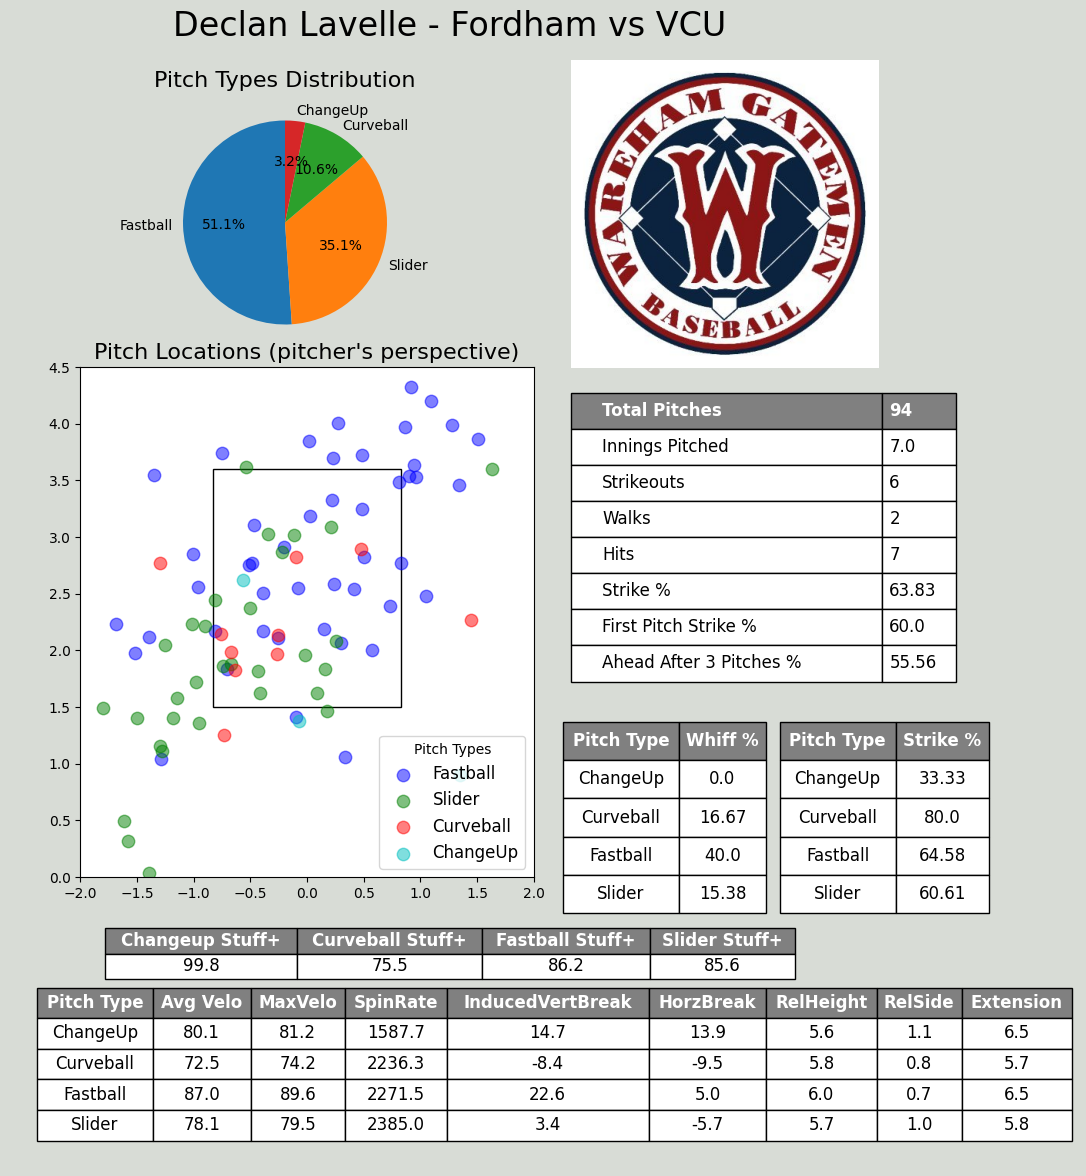

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import pickle
import numpy as np
import matplotlib.image as mpimg

def get_pitcher_name():
    first_name = input("Enter the pitcher's first name: ")
    last_name = input("Enter the pitcher's last name: ")
    return last_name + ", " + first_name

def calculate_a3p(pitcher_name):
    df = pd.read_csv("/Users/johndavis/Desktop/Fordham_VCU.csv", low_memory=False)
    df_pitcher = df[df['Pitcher'] == pitcher_name]
    df_pitcher_three_pitches = df_pitcher[df_pitcher['PitchofPA'] >= 3]
    a3p = (df_pitcher_three_pitches[df_pitcher_three_pitches['Strikes'] >= 2].shape[0] / df_pitcher_three_pitches.shape[0]) * 100
    return a3p

def generate_report(df, pitcher_name):
    if 'TaggedPitchType' not in df.columns:
        raise KeyError("Column 'TaggedPitchType' not found in DataFrame")
    
    pitcher_data = df[df['Pitcher'] == pitcher_name]
    pitcher_data = pitcher_data[pitcher_data['TaggedPitchType'].notna()]
    pitcher_data = pitcher_data[pitcher_data['TaggedPitchType'] != 'Undefined']
    first_name, last_name = pitcher_name.split(', ')
    formatted_pitcher_name = f"{last_name} {first_name}"
    
    pitch_type_counts = pitcher_data['TaggedPitchType'].value_counts()
    pitch_type_averages = pitcher_data.groupby('TaggedPitchType')[['RelSpeed', 'SpinRate', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'Extension']].mean()
    pitch_type_averages.reset_index(inplace=True)
    pitch_type_averages['differential_break'] = abs(pitch_type_averages['InducedVertBreak'].abs() - pitch_type_averages['HorzBreak'].abs())
    pitch_type_averages['ABS_Horizontal'] = pitch_type_averages['HorzBreak'].abs()
    pitch_type_averages['ABS_RelSide'] = pitch_type_averages['RelSide'].abs()
    
    a3p = calculate_a3p(pitcher_name)
    strikes = pitcher_data[pitcher_data['PitchCall'].isin(['StrikeCalled', 'StrikeSwinging', 'FoulBall', 'InPlay', 'FoulBallNotFieldable', 'FoulBallFieldable'])]
    strike_percentages = strikes.groupby('TaggedPitchType')['PitchCall'].count() / pitch_type_counts * 100
    strike_percentages = strike_percentages.fillna(0)
    
    pitch_type_max_velocity = pitcher_data.groupby('TaggedPitchType')['RelSpeed'].max().reset_index()
    pitch_type_max_velocity.rename(columns={'RelSpeed': 'MaxVelo'}, inplace=True)
    pitch_type_averages = pitch_type_averages.merge(pitch_type_max_velocity, on='TaggedPitchType', how='left')

    cols = pitch_type_averages.columns.tolist()
    cols.insert(cols.index('RelSpeed') + 1, cols.pop(cols.index('MaxVelo')))
    pitch_type_averages = pitch_type_averages[cols]
    
    hits = len(pitcher_data[pitcher_data['PlayResult'].isin(['Single', 'Double', 'Triple', 'HomeRun'])])
    total_pitches = len(pitcher_data)
    strikeouts = len(pitcher_data[pitcher_data['KorBB'] == 'Strikeout'])
    walks = len(pitcher_data[pitcher_data['KorBB'] == 'Walk'])
    
    outs_pitch = (pitcher_data['Outs'].diff() > 0).sum()
    outs_play = len(pitcher_data[pitcher_data['PlayResult'].isin(['Out', 'Sacrifice'])])
    total_outs = outs_pitch + outs_play

    innings_pitched = total_outs / 3
    
    is_fastball = pitch_type_averages['TaggedPitchType'].isin(['Fastball'])
    fb_metrics_stuff = pitch_type_averages[is_fastball][['RelSpeed','SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']]
    
    is_sinker = pitch_type_averages['TaggedPitchType'].isin(['Sinker'])
    fb_metrics_stuff1 = pitch_type_averages[is_sinker][['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']]
        
    is_two_seam = pitch_type_averages['TaggedPitchType'].isin(['TwoSeamFastball'])
    fb_metrics_stuff2 = pitch_type_averages[is_two_seam][['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']]
        
    is_four_seam = pitch_type_averages['TaggedPitchType'].isin(['FourSeamFastball'])
    fb_metrics_stuff3 = pitch_type_averages[is_four_seam][['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension']]
    
    is_curveball = pitch_type_averages['TaggedPitchType'] == 'Curveball'
    cb_metrics_stuff = pitch_type_averages[is_curveball][['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal', 'RelHeight', 'ABS_RelSide', 'Extension']]
    
    is_slider = pitch_type_averages['TaggedPitchType'].isin(['Slider'])
    sl_metrics_stuff = pitch_type_averages[is_slider][['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal', 'RelHeight', 'ABS_RelSide', 'Extension']]
     
    is_cutter = pitch_type_averages['TaggedPitchType'].isin(['Cutter'])
    sl_metrics_stuff1 = pitch_type_averages[is_cutter][['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal', 'RelHeight', 'ABS_RelSide', 'Extension']]
    
    is_changeup = pitch_type_averages['TaggedPitchType'] == 'ChangeUp'
    ch_metrics_stuff = pitch_type_averages[is_changeup][['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal', 'RelHeight', 'ABS_RelSide', 'Extension']]
        
    is_splitter = pitch_type_averages['TaggedPitchType'] == 'Splitter'
    ch_metrics_stuff1 = pitch_type_averages[is_splitter][['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal', 'RelHeight', 'ABS_RelSide', 'Extension']]
    
    xgb_models = {
        'Fastball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelfb.sav', 'rb')),
        'Sinker': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelfb.sav', 'rb')),
        'TwoSeamFastball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelfb.sav', 'rb')),
        'FourSeamFastball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelfb.sav', 'rb')),
        'Curveball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelcb.sav', 'rb')),
        'Slider': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelsl.sav', 'rb')),
        'Cutter': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelsl.sav', 'rb')),
        'ChangeUp': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelch.sav', 'rb')),
        'Splitter': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/xgb_modelch.sav', 'rb'))
    }
    
    rf_models = {
        'Fastball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelfb.sav', 'rb')),
        'Sinker': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelfb.sav', 'rb')),
        'TwoSeamFastball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelfb.sav', 'rb')),
        'FourSeamFastball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelfb.sav', 'rb')),
        'Curveball': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelcb.sav', 'rb')),
        'Slider': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelsl.sav', 'rb')),
        'Cutter': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelsl.sav', 'rb')),
        'ChangeUp': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelch.sav', 'rb')),
        'Splitter': pickle.load(open('/Users/johndavis/Desktop/Stuff_Models/rfc_modelch.sav', 'rb'))
    }
    
    unique_pitch_types = pitch_type_averages['TaggedPitchType'].unique()
    df_stuff = pd.DataFrame()
    
    whiff_constants = {
        'Fastball': 0.17714710533618927,
        'Sinker': 0.17714710533618927,
        'TwoSeamFastball': 0.17714710533618927,
        'FourSeamFastball': 0.17714710533618927,
        'Curveball': 0.2957040071487427,
        'Slider': 0.3236396014690399,
        'Cutter': 0.3236396014690399,
        'ChangeUp': 0.32178011536598206,
        'Splitter': 0.32178011536598206
    }
    
    for pitch in unique_pitch_types:
        if pitch in whiff_constants:
            features = ['RelSpeed', 'SpinRate', 'differential_break', 'RelHeight', 'ABS_RelSide', 'Extension'] if pitch in ['Fastball', 'Sinker'] else ['RelSpeed', 'SpinRate', 'InducedVertBreak', 'ABS_Horizontal', 'RelHeight', 'ABS_RelSide', 'Extension']
            pitch_metrics = pitch_type_averages[pitch_type_averages['TaggedPitchType'] == pitch][features].copy()
            model = xgb_models[pitch]
            model_2 = rf_models[pitch]
            proba_predictions_1 = model.predict_proba(pitch_metrics)[:, 1]
            proba_predictions_2 = model_2.predict_proba(pitch_metrics)[:, 1]
            proba_predictions = (proba_predictions_1 + proba_predictions_2) / 2
            df_stuff[pitch] = (proba_predictions / whiff_constants[pitch]) * 100
    
    df_stuff = df_stuff.round(2)
    df_stuff.rename(columns={
        'Fastball': 'Fastball Stuff+',
        'FourSeamFastball': 'Four-Seam Fastball Stuff+',
        'TwoSeamFastball': 'Two-Seam Fastball Stuff+',
        'Sinker': 'Sinker Stuff+',
        'Curveball': 'Curveball Stuff+',
        'Slider': 'Slider Stuff+',
        'Cutter': 'Cutter Stuff+',
        'ChangeUp': 'Changeup Stuff+',
        'Splitter': 'Splitter Stuff+'
    }, inplace=True)

    first_pitches = pitcher_data[pitcher_data['PitchofPA'] == 1]
    first_pitch_strikes = first_pitches[first_pitches['PitchCall'].isin(['StrikeCalled', 'StrikeSwinging', 'FoulBall', 'InPlay', 'FoulBallNotFieldable', 'FoulBallFieldable'])]
    first_pitch_strike_percentage = len(first_pitch_strikes) / len(first_pitches) * 100
    total_Strike_percentage = len(strikes) / total_pitches * 100
    pitch_type_averages_1 = pitch_type_averages[['TaggedPitchType', 'RelSpeed','MaxVelo','SpinRate', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'Extension']]
    #rename columns
    pitch_type_averages_1.rename(columns={
        'TaggedPitchType': 'Pitch Type',
        'RelSpeed': 'Avg Velo'
    }, inplace=True)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.mean())
    
    total_swings = pitcher_data[pitcher_data['PitchCall'].isin(['StrikeSwinging', 'FoulBall', 'InPlay', 'FoulBallNotFieldable', 'FoulBallFieldable'])].groupby('TaggedPitchType').size()
    whiffs = pitcher_data[pitcher_data['PitchCall'] == 'StrikeSwinging'].groupby('TaggedPitchType').size()
    whiff_percentages = (whiffs / total_swings) * 100
    whiff_percentages = whiff_percentages.fillna(0)
    
    logo_img = mpimg.imread('/Users/johndavis/Desktop/Wareham.jpg')  # Replace with the path to your image
    
    with PdfPages("/Users/johndavis/Desktop/pitcher_report.pdf") as pdf:
        fig = plt.figure(figsize=(11, 17))
        fig.patch.set_facecolor('xkcd:light grey')
    
        ax1 = fig.add_subplot()
        ax1.pie(pitch_type_counts, labels=pitch_type_counts.index, autopct='%1.1f%%', startangle=90)
        ax1.set_title('Pitch Types Distribution', fontsize=16)
        ax1.set_position([0.175, 0.78, 0.35, 0.15])
    
        ax2 = fig.add_subplot()
        ax2.axis('off')
        basic_stats_data = [
            ['Total Pitches', total_pitches],
            ['Innings Pitched', innings_pitched],
            ['Strikeouts', strikeouts],
            ['Walks', walks],
            ['Hits', hits],
            ['Strike %', round(total_Strike_percentage, 2)],
            ['First Pitch Strike %', round(first_pitch_strike_percentage, 2)],
            ['Ahead After 3 Pitches %', round(a3p, 2)]
        ]
        basic_stats_table = ax2.table(cellText=basic_stats_data, cellLoc='left', loc='center', colLabels=None, bbox=[0, 0, 1, 1])
        basic_stats_table.auto_set_font_size(False)
        basic_stats_table.set_fontsize(12)
        basic_stats_table.auto_set_column_width(col=list(range(2)))
        for (i, j), cell in basic_stats_table._cells.items():
            if i == 0:
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('gray')
            cell.set_height(0.15)
        ax2.set_position([0.61, 0.585, .35, 0.17])
    
        ax3 = fig.add_subplot()
        ax3.axis('off')
        pitch_type_averages_table = ax3.table(cellText=pitch_type_averages_1.round(1).values,
                                              colLabels=pitch_type_averages_1.columns,
                                              cellLoc='center', loc='center')
        pitch_type_averages_table.auto_set_font_size(False)
        pitch_type_averages_table.set_fontsize(12)
        pitch_type_averages_table.auto_set_column_width(col=list(range(len(pitch_type_averages_1.columns))))
        for (i, j), cell in pitch_type_averages_table._cells.items():
            if i == 0:
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('gray')
            cell.set_height(0.15)
        ax3.set_position([0.42, 0.30, 0.35, 0.12])
    
        ax4 = fig.add_subplot()
        strike_zone = Rectangle((-0.83, 1.5), 1.66, 2.1, linewidth=1, edgecolor='k', facecolor='none')
        ax4.add_patch(strike_zone)
        ax4.set_xlim(-2, 2)
        ax4.set_ylim(0, 4.5)
        ax4.set_aspect('equal')
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
        for idx, pitch_type in enumerate(pitch_type_counts.index):
            filtered_data = pitcher_data[pitcher_data['TaggedPitchType'] == pitch_type]
            ax4.scatter(filtered_data['PlateLocSide'], filtered_data['PlateLocHeight'], s=80, c=colors[idx], alpha=0.5, label=pitch_type)
        ax4.legend(title="Pitch Types", fontsize=12)
        ax4.set_title("Pitch Locations (pitcher's perspective)", fontsize=16)
        ax4.set_position([0.12, 0.47, 0.5, 0.3])
    
        ax5 = fig.add_subplot()
        ax5.axis('off')
        strike_percentages_data = [[pitch_type, round(strike_percentages[pitch_type], 2)] for pitch_type in strike_percentages.index]
        strike_percentages_table = ax5.table(cellText=strike_percentages_data,
                                             colLabels=['Pitch Type', 'Strike %'],
                                             cellLoc='center', loc='center')
        strike_percentages_table.auto_set_font_size(False)
        strike_percentages_table.set_fontsize(12)
        strike_percentages_table.auto_set_column_width(col=list(range(2)))
        for (i, j), cell in strike_percentages_table._cells.items():
            if i == 0:
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('gray')
            cell.set_height(0.15)
        ax5.set_position([0.72, 0.43, 0.35, 0.15])
    
        ax6 = fig.add_subplot()
        ax6.axis('off')
        whiff_percentages_data = [[pitch_type, round(whiff_percentages[pitch_type], 2)] for pitch_type in whiff_percentages.index]
        whiff_percentages_table = ax6.table(cellText=whiff_percentages_data,
                                            colLabels=['Pitch Type', 'Whiff %'],
                                            cellLoc='center', loc='center')
        whiff_percentages_table.auto_set_font_size(False)
        whiff_percentages_table.set_fontsize(12)
        whiff_percentages_table.auto_set_column_width(col=list(range(2)))
        for (i, j), cell in whiff_percentages_table._cells.items():
            if i == 0:
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('gray')
            cell.set_height(0.15)
        ax6.set_position([0.52, 0.43, 0.35, 0.15])
    
        ax7 = fig.add_subplot()
        ax7.axis('off')
        stuff_metrics_table = ax7.table(cellText=df_stuff.round(1).values,
                                        colLabels=df_stuff.columns,
                                        cellLoc='center', loc='center')
        stuff_metrics_table.auto_set_font_size(False)
        stuff_metrics_table.set_fontsize(12)
        stuff_metrics_table.auto_set_column_width(col=list(range(len(df_stuff.columns))))
        for (i, j), cell in stuff_metrics_table._cells.items():
            if i == 0:
                cell.set_text_props(weight='bold')
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor('grey')
                cell.set_height(0.1)
            else:
                cell.set_height(0.1)  # Increase the height for value rows
        ax7.set_position([0.1, 0.35, 0.8, 0.15])
    
        ax_logo = fig.add_axes([0.61, 0.72, 0.28, 0.28])  # Adjust the numbers as needed to position your image
        ax_logo.axis('off')  # We don't want any axis for the logo
        ax_logo.imshow(logo_img)
        
    
        plt.suptitle(f"{formatted_pitcher_name} - Fordham vs VCU", fontsize=24)
        pdf.savefig(fig, bbox_inches='tight')
        pdf.close()

df = pd.read_csv("/Users/johndavis/Desktop/Fordham_VCU.csv", low_memory=False)
pitcher_name = get_pitcher_name()
generate_report(df, pitcher_name)

